In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv(".\\DATA\\Telco-Customer-Churn.csv")

### Train Test Split

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
X = df.drop(["Churn", "customerID"], axis=1)
X = pd.get_dummies(X)

In [6]:
y = df["Churn"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### GridSerach Cross Validation

In [26]:
n_estimators = [10,20,50,100]
max_features = ["sqrt", "log2", None]
learning_rate_ada = [0.05,0.5,1.,1.5, 3]
learning_rate_gradient = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
max_depth = [2,3,4,5,6,7]

In [27]:
param_grid_random = {"n_estimators": n_estimators, "max_features": max_features}

param_grid_ada = {"n_estimators":n_estimators, "learning_rate":learning_rate_ada}

param_grid_gradient = {"learning_rate":learning_rate_gradient, "n_estimators":n_estimators,"max_depth":max_depth, "max_features":max_features}

In [10]:
rfc = RandomForestClassifier()

In [11]:
abc = AdaBoostClassifier()

In [12]:
gbc = GradientBoostingClassifier()

In [28]:
def fitter(estimator, param_grid, X_train):
    grid_model = GridSearchCV(estimator, param_grid)
    grid_model.fit(X_train, y_train)
    grid_model = grid_model.best_estimator_
    return grid_model

In [67]:
grid_rfc = fitter(rfc, param_grid_random, X_train)

In [68]:
grid_rfc

RandomForestClassifier()

In [16]:
grid_abc = fitter(abc, param_grid_ada, X_train)

In [69]:
grid_abc

AdaBoostClassifier(learning_rate=0.5)

In [71]:
grid_gbc = fitter(gbc, param_grid_gradient, X_train)

In [72]:
grid_gbc

GradientBoostingClassifier(max_features='log2')

In [63]:
def evaluate(estimator, X_test): 
    print(f"{estimator}")
    predictions = estimator.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    print(classification_report(y_test, predictions))
    
    def change(value):
        if value == "Yes":
            return True
        else: 
            return False
        
    v_change = np.vectorize(change)
    print(f"roc_auc_score = {round(roc_auc_score(v_change(y_test), v_change(predictions)), 2)}")

RandomForestClassifier(n_estimators=50)
              precision    recall  f1-score   support

          No       0.82      0.90      0.86       511
         Yes       0.64      0.47      0.54       193

    accuracy                           0.78       704
   macro avg       0.73      0.68      0.70       704
weighted avg       0.77      0.78      0.77       704

roc_auc_score = 0.68


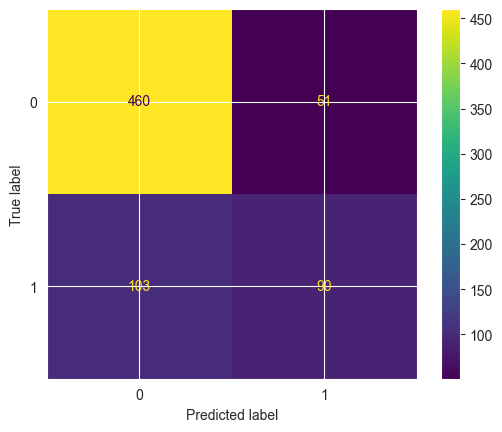

In [64]:
evaluate(grid_rfc, X_test)

AdaBoostClassifier(learning_rate=0.5)
              precision    recall  f1-score   support

          No       0.83      0.91      0.86       511
         Yes       0.67      0.49      0.57       193

    accuracy                           0.79       704
   macro avg       0.75      0.70      0.72       704
weighted avg       0.78      0.79      0.78       704

roc_auc_score = 0.7


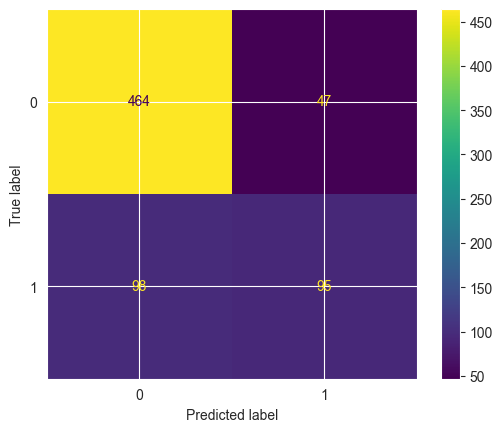

In [65]:
evaluate(grid_abc, X_test)

GradientBoostingClassifier(max_features='log2')
              precision    recall  f1-score   support

          No       0.82      0.91      0.86       511
         Yes       0.66      0.48      0.55       193

    accuracy                           0.79       704
   macro avg       0.74      0.69      0.71       704
weighted avg       0.78      0.79      0.78       704

roc_auc_score = 0.69


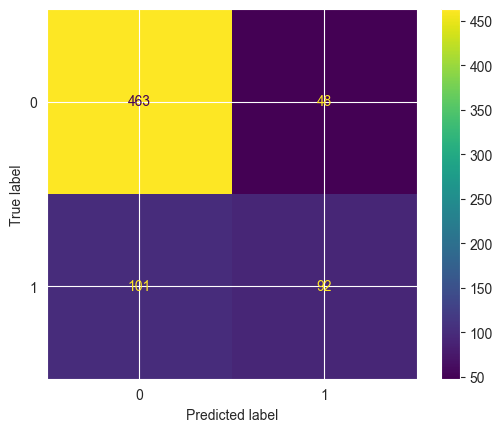

In [73]:
evaluate(grid_gbc, X_test)

### Further AdaBoostClassifier adjustment

In [46]:
grid_abc

AdaBoostClassifier(learning_rate=0.5)

In [83]:
n_estimators_second = [40,50,60]
learning_rate_ada_second = [0.4, 0.5, 0.6]
param_grid_ada_second = {"n_estimators": n_estimators_second, "learning_rate": learning_rate_ada_second}

In [84]:
grid_abc_second = fitter(abc, param_grid_ada_second, X_train)

In [85]:
grid_abc_second

AdaBoostClassifier(learning_rate=0.4)

AdaBoostClassifier(learning_rate=0.4)
              precision    recall  f1-score   support

          No       0.82      0.90      0.86       511
         Yes       0.66      0.49      0.56       193

    accuracy                           0.79       704
   macro avg       0.74      0.70      0.71       704
weighted avg       0.78      0.79      0.78       704

roc_auc_score = 0.7


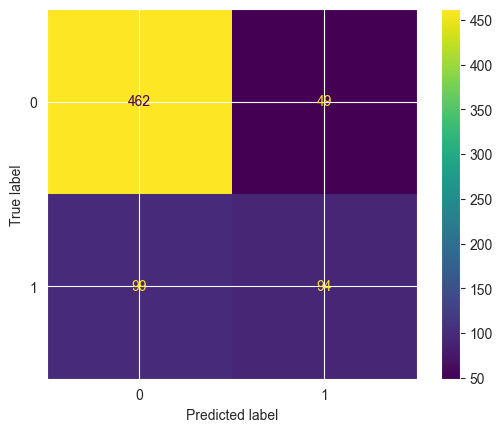

In [86]:
evaluate(grid_abc_second, X_test)

### Support vector classifier adjustment

In [76]:
svc = SVC()

In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
param_grid_svc = {"C":[0.0001, 0.001, 0.01, 0.1, 1, 1.1, 10, 100], "gamma": ["scale", "auto"], "kernel": ["linear", "rbf"], "class_weight":[None, "balanced"]}

In [80]:
grid_svc = fitter(svc, param_grid_svc,X_train_scaled)

In [81]:
grid_svc

SVC(C=1.1, kernel='linear')

SVC(C=1.1, kernel='linear')
              precision    recall  f1-score   support

          No       0.83      0.89      0.86       511
         Yes       0.64      0.52      0.57       193

    accuracy                           0.79       704
   macro avg       0.73      0.70      0.72       704
weighted avg       0.78      0.79      0.78       704

roc_auc_score = 0.7


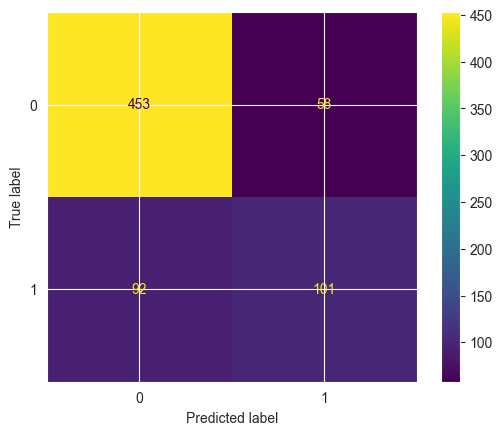

In [82]:
evaluate(grid_svc, X_test_scaled)